# Predict Movie Licensing Revenue Category for Watch-It

## Business Context
Watch-It is a media services company whose revenue is influenced by advertising and brand integrations.
Licensing titles that attract more viewers and engagement increases revenue potential.

## Objective
Build a robust machine learning model to predict `revenue_category` (**High** / **Low**) using historical movie metadata,
engagement signals, ratings, and awards.

## Deliverables
- A well-documented notebook explaining methodology and reasoning
- `submissions.csv` with exactly two columns:
  - `title`
  - `revenue_category` (High/Low)

## Approach
1. Load data & integrity checks  
2. EDA (target patterns, missingness, feature–target relationships)  
3. Cleaning & standardization (convert text → numeric, normalize categories, parse dates)  
4. Feature engineering (timing + engagement quality + scale transforms)  
5. Preprocessing pipeline (impute + encode + scale)  
6. Model selection (5-fold stratified CV)  
7. Train final model & generate submission  

## 1. Setup & Imports

In [7]:
import os
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("Environment ready.")

Environment ready.


## 2. Load Data & Integrity Checks

We load the train/test datasets and perform basic integrity checks to confirm:
- schema consistency between train and test
- the target column exists only in train
- duplicates and missingness patterns
- class distribution of the target

In [5]:
# =============================
# Load Data & Integrity Checks
# =============================


DATA_DIR = "."

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")
SAMPLE_SUB_PATH = os.path.join(DATA_DIR, "sample_submission.csv")

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

TARGET = "revenue_category"
ID_COL = "title"

print(f"Train shape: {train.shape}")
print(f"Test shape : {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

# Schema checks
assert TARGET in train.columns, "Target column missing in train."
assert TARGET not in test.columns, "Target should not exist in test (leakage risk)."
assert ID_COL in train.columns and ID_COL in test.columns, "Title column missing."

assert set(sample_sub.columns) == {ID_COL, TARGET}, "sample_submission schema mismatch."

display(train.head(3))
display(test.head(3))
display(sample_sub.head(3))

Train shape: (2400, 22)
Test shape : (600, 21)
Sample submission shape: (1, 2)


,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
0,Pooh's Heffalump Movie,USA,"Animation, Comedy, Family, Fantasy, Musical, M...",English,3.0,True,G,11-Feb-05,68 min,24-May-05,"5,654",NaN,NaN,NaN,NaN,6.4/10,80%,64/100,0,0,1,High
1,Yeh Jawaani Hai Deewani,India,"Comedy, Drama, Musical, Romance","Hindi, English, French",2.0,True,Not Rated,31-May-13,160 min,15-Jul-13,"33,860",9.0,124.0,127528.0,12.0,7.1/10,67%,0,0,22,92,Low
2,Tae Guk Gi: The Brotherhood of War,South Korea,"Action, Drama, War",Korean,4.0,False,R,24-Sep-04,140 min,15-Feb-05,"35,697",268.0,614.0,351123.0,18.0,8.1/10,80%,64/100,0,12,7,Low


,title,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination
0,Delhi-6,India,"Comedy, Drama","Hindi, English",3.0,True,Not Rated,20-Feb-09,141 min,16-Jun-09,"6,337",7.0,43.0,165008.0,13.0,6.0/10,40%,45/100,0,2,7
1,Before I Disappear,"USA, UK",Drama,English,1.0,False,Unrated,28-Nov-14,93 min,19-May-15,"8,370",NaN,NaN,NaN,NaN,7.2/10,38%,47/100,0,16,8
2,"Good Year, A","USA, UK","Comedy, Drama, Romance","English, French, Russian",2.0,True,PG-13,10-Nov-06,117 min,27-Feb-07,"82,062",14.0,276.0,187788.0,17.0,7.0/10,25%,47/100,0,1,2


,title,revenue_category
0,Delhi-6,Low


In [6]:
# Duplicate checks
dup_rows = train.duplicated().sum()
dup_titles = train[ID_COL].duplicated().sum()
print(f"Duplicate rows (train): {dup_rows}")
print(f"Duplicate titles (train): {dup_titles}")

# Missingness
missing_pct = (train.isna().mean().sort_values(ascending=False) * 100).round(2)
display(missing_pct.head(12).to_frame("missing_%"))

# Target distribution
target_counts = train[TARGET].value_counts()
target_pct = train[TARGET].value_counts(normalize=True).mul(100).round(2)
display(pd.DataFrame({"count": target_counts, "percent": target_pct}))

Duplicate rows (train): 0
Duplicate titles (train): 12


,missing_%
dislikes,18.50
likes,18.50
comments,17.75
overall_views,13.21
writer_count,3.92
dvd_release_date,2.88
censor_rating,1.58
language,0.21
release_date,0.17
title,0.08


,count,percent
revenue_category,,
High,1221,50.88
Low,1179,49.12


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2398 non-null   object 
 1   country             2400 non-null   object 
 2   genres              2400 non-null   object 
 3   language            2395 non-null   object 
 4   writer_count        2306 non-null   float64
 5   title_adaption      2400 non-null   bool   
 6   censor_rating       2362 non-null   object 
 7   release_date        2396 non-null   object 
 8   runtime             2400 non-null   object 
 9   dvd_release_date    2331 non-null   object 
 10  users_votes         2400 non-null   object 
 11  comments            1974 non-null   float64
 12  likes               1956 non-null   float64
 13  overall_views       2083 non-null   float64
 14  dislikes            1956 non-null   float64
 15  ratings_imdb        2400 non-null   object 
 16  rating

### Interpretation

- The train and test sets share the same feature schema, with the target (`revenue_category`) present only in train, as expected.
- The presence of duplicate `title` values indicates that `title` is **not a unique identifier** and should be used primarily for submission output rather than as a predictive feature.
- Missing values are concentrated in engagement metrics (`likes`, `dislikes`, `comments`, `overall_views`), which is realistic (not every title has complete trailer statistics). These will be handled through imputation within a preprocessing pipeline.
- The target distribution is approximately balanced, so both **Accuracy** and **F1-score** are appropriate evaluation metrics; we will prioritize F1 for robustness.

## 3. Exploratory Data Analysis (EDA)

### Purpose
The EDA is used to understand:
- How engagement, ratings, and awards relate to revenue category
- Whether missingness is systematic (and therefore informative)
- Potential transformations needed (skewness, outliers, scaling)
- Early hypotheses that guide feature engineering and model choice

### EDA Focus
We focus on analyses that are:
- directly relevant to the target (`revenue_category`)
- likely to influence modeling decisions
- interpretable for business stakeholders

,count,percent
revenue_category,,
High,1221,50.88
Low,1179,49.12


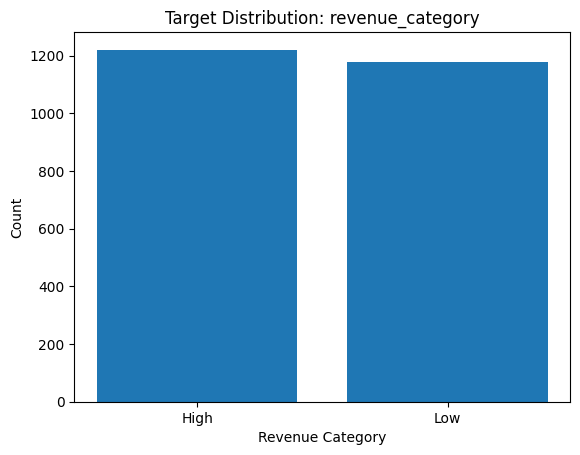

In [8]:
# =========================
#  Target balance
# =========================

target_counts = train[TARGET].value_counts()
target_pct = train[TARGET].value_counts(normalize=True).mul(100).round(2)
display(pd.DataFrame({"count": target_counts, "percent": target_pct}))

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution: revenue_category")
plt.xlabel("Revenue Category")
plt.ylabel("Count")
plt.show();

### Inference
The target distribution is approximately balanced, which reduces the risk of trivial majority-class prediction.
We will still report F1-score (robust) and Accuracy (intuitive) to provide a comprehensive evaluation.

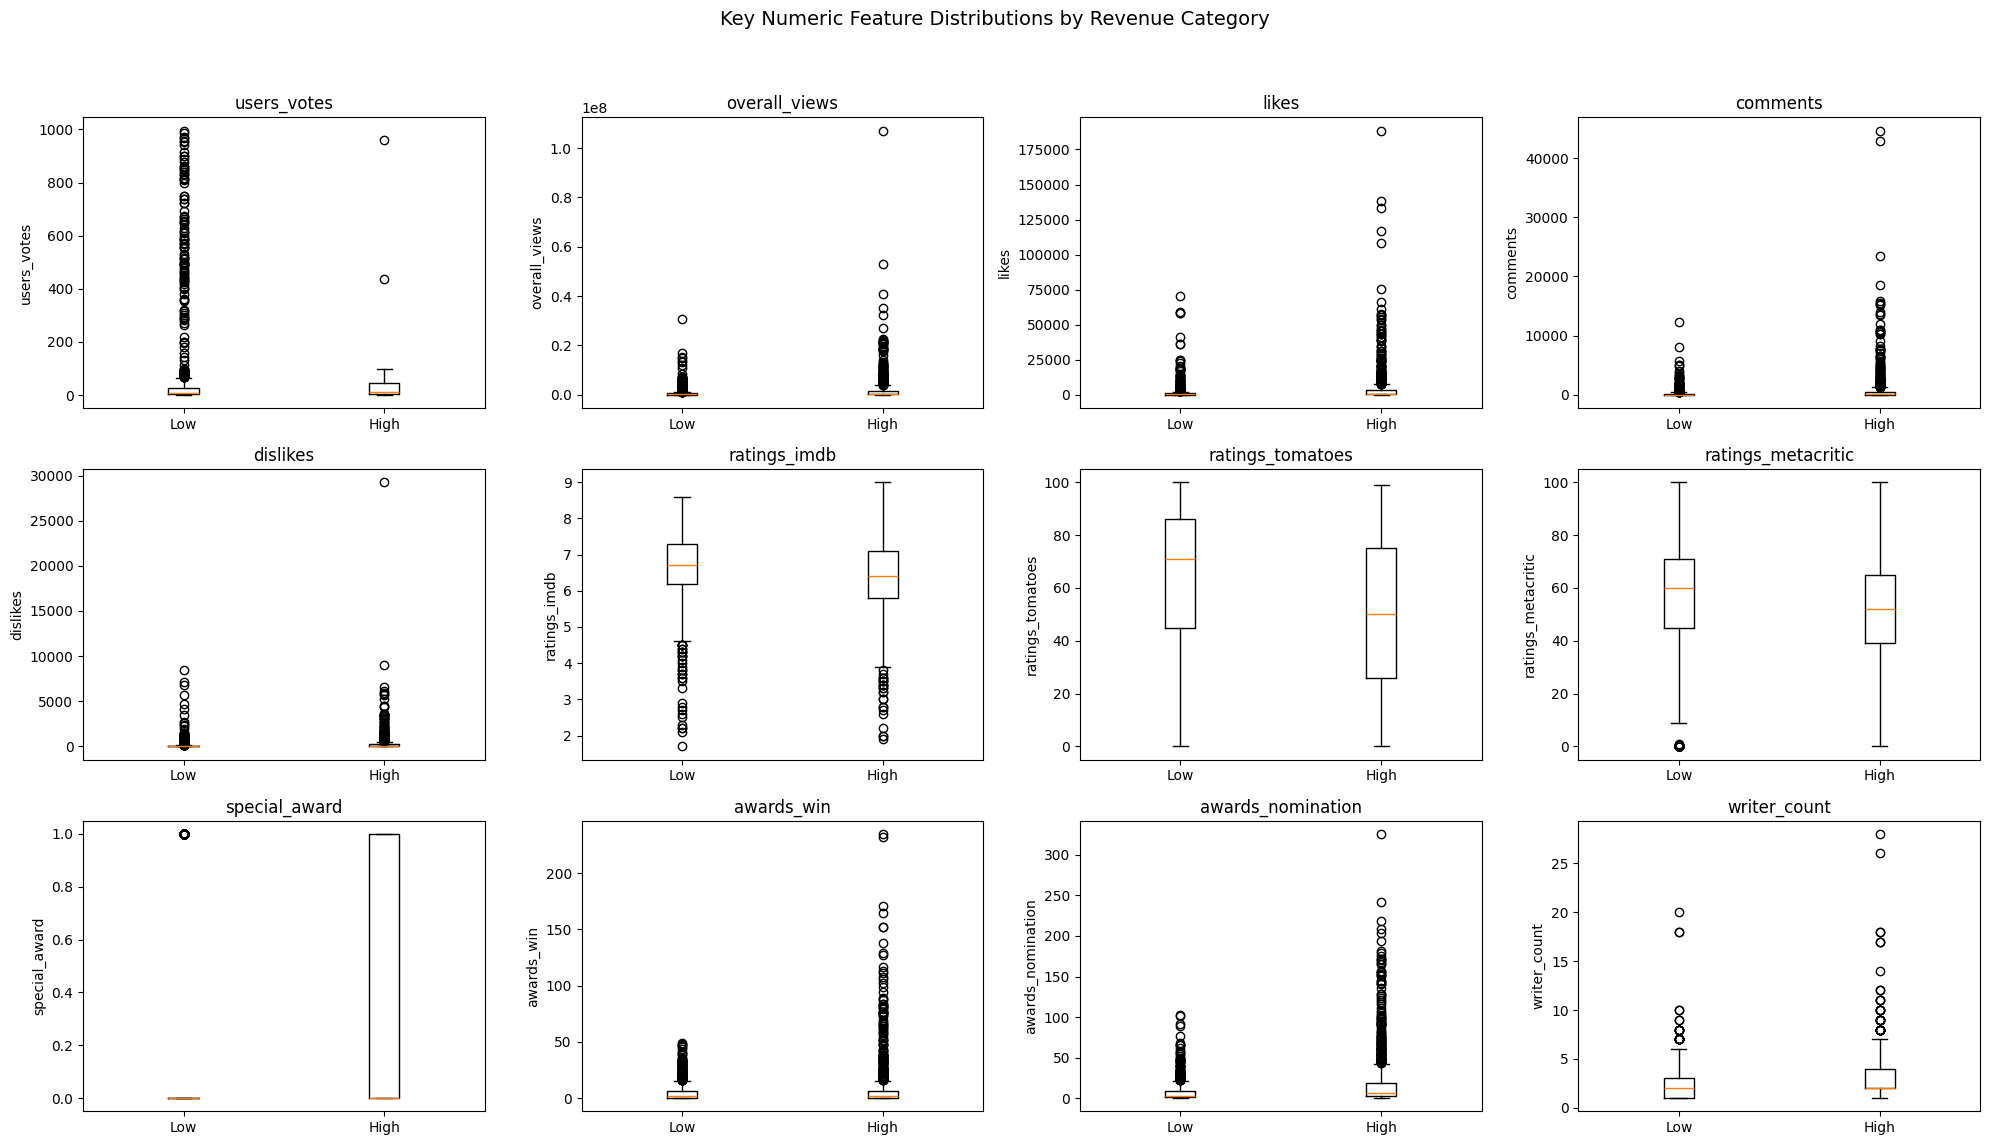

In [9]:
# =================================================
#  Key numeric features by target (4 plots per row)
# =================================================

# Create a numeric-only copy for EDA (no side effects on main dataset)
eda_df = train.copy()

numeric_eda_cols = [
    "users_votes", "overall_views", "likes", "comments", "dislikes",
    "ratings_imdb", "ratings_tomatoes", "ratings_metacritic",
    "special_award", "awards_win", "awards_nomination", "writer_count"
]

# Coerce to numeric for visualization only
for c in numeric_eda_cols:
    if c in eda_df.columns:
        eda_df[c] = pd.to_numeric(
            eda_df[c].astype(str).str.extract(r"([\d\.]+)")[0],
            errors="coerce"
        )

# Layout configuration
n_cols = 4
valid_cols = [c for c in numeric_eda_cols if c in eda_df.columns]

n_plots = len(valid_cols)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, c in enumerate(valid_cols):
    low = eda_df.loc[eda_df[TARGET] == "Low", c].dropna()
    high = eda_df.loc[eda_df[TARGET] == "High", c].dropna()

    if low.empty or high.empty:
        continue

    axes[i].boxplot([low, high], labels=["Low", "High"])
    axes[i].set_title(c)
    axes[i].set_ylabel(c)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Key Numeric Feature Distributions by Revenue Category", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Executive EDA Summary (Key Insights)

- **Engagement intensity is the strongest driver of revenue**: High-revenue titles consistently show higher medians and upper tails for views, likes, comments, and votes.
- **Engagement features are extremely skewed**, with many outliers, which will need log transformations and rate-based features rather than raw counts.
- **Negative feedback (dislikes) scales with exposure**, indicating it reflects reach rather than poor performance; ratios are more informative than absolute values.
- **Ratings provide complementary but insufficient signal on their own**, showing overlap between classes and reinforcing the need for interaction-aware models.
- **Awards act as a nonlinear revenue amplifier**: most Low-revenue titles cluster near zero, while High-revenue titles include many extreme values.
- **No single feature is decisive**, motivating the use of ensemble models capable of capturing nonlinear relationships and feature interactions.

These insights directly informed feature engineering choices and the selection of Gradient Boosting as the final model.

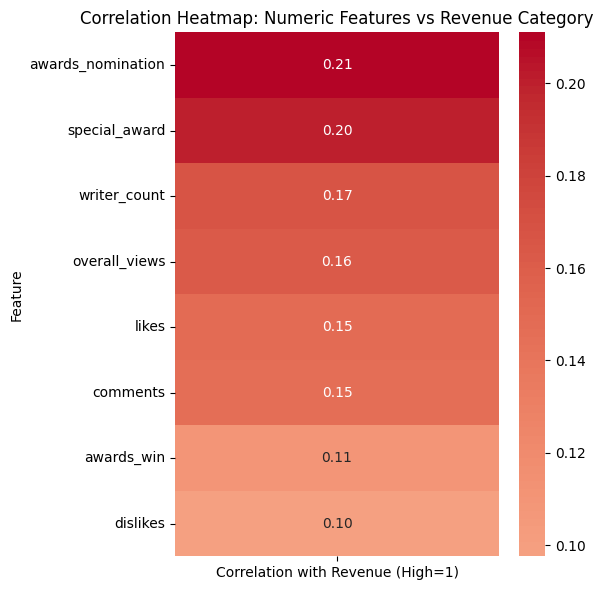

In [12]:
# ===============================================
# EDA: Correlation heatmap (numeric vs target)
# ===============================================


# Encode target for correlation analysis only
y_bin = train[TARGET].map({"Low": 0, "High": 1})

# Select numeric features
numeric_cols_raw = train.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation with target
corr_with_target = (
    train[numeric_cols_raw]
    .corrwith(y_bin)
    .sort_values(ascending=False)
)

# Convert to DataFrame for heatmap
corr_df = corr_with_target.to_frame(name="Correlation with Revenue (High=1)")

plt.figure(figsize=(6, max(6, 0.35 * len(corr_df))))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)
plt.title("Correlation Heatmap: Numeric Features vs Revenue Category")
plt.xlabel("")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [14]:
# ===============================================
#  Correlation with target (numeric fields only)
# ===============================================

display(corr_df.head(10))
display(corr_df.tail(10))

,Correlation with Revenue (High=1)
awards_nomination,0.211012
special_award,0.200746
writer_count,0.167796
overall_views,0.161648
likes,0.149727
comments,0.146094
awards_win,0.109905
dislikes,0.097628


,Correlation with Revenue (High=1)
awards_nomination,0.211012
special_award,0.200746
writer_count,0.167796
overall_views,0.161648
likes,0.149727
comments,0.146094
awards_win,0.109905
dislikes,0.097628


### Inference
This correlation view provides a fast signal check for numeric drivers of revenue category.
It does not capture nonlinear relationships, which motivates testing tree/boosting models alongside linear baselines.

,freq,high_rate
genre,,
Drama,1358,0.423417
Comedy,870,0.595402
Thriller,618,0.632686
Romance,550,0.520000
Action,425,0.731765
Crime,416,0.557692
Adventure,328,0.817073
Family,237,0.827004
Documentary,235,0.089362


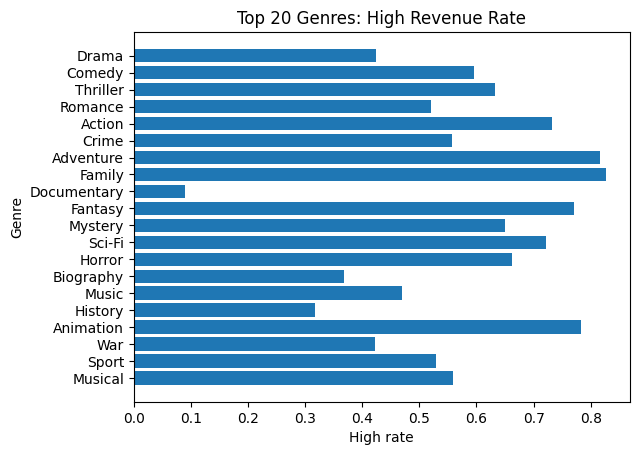

In [17]:
# ======================================
#  Genre impact (frequency + High-rate)
# ======================================

def explode_multivalue(df, col, sep=","):
    s = df[col].fillna("").astype(str)
    exploded = s.str.split(sep).explode().str.strip()
    exploded = exploded[exploded != ""]
    return exploded

genres_exploded = explode_multivalue(train, "genres")

genre_df = pd.DataFrame({
    "genre": genres_exploded.values,
    "target": train.loc[genres_exploded.index, TARGET].values
})

genre_summary = (
    genre_df.groupby("genre")
            .agg(freq=("genre", "count"),
                 high_rate=("target", lambda x: (x == "High").mean()))
            .sort_values("freq", ascending=False)
)

display(genre_summary.head(20))

top20 = genre_summary.head(20).copy()
plt.figure()
plt.barh(top20.index[::-1], top20["high_rate"][::-1])
plt.title("Top 20 Genres: High Revenue Rate")
plt.xlabel("High rate")
plt.ylabel("Genre")
plt.show()

## EDA Summary (Key Takeaways)

1. **Engagement metrics** (views/likes/comments/votes) are strongly related to revenue outcomes.
2. Engagement features show **missingness**, which may itself be informative.
3. **Ratings and awards** contribute signal but require robust parsing + imputation.
4. Several count variables are heavy-tailed → **log transforms** are justified.
5. Multi-value fields (genres/country/language) contain meaningful structure → **multi-hot encoding** is required.

These insights directly guide the data cleaning, feature engineering, and model selection steps that follow.

## 4. Data Profiling Summary (Parsing Requirements)

This cell confirms which columns require parsing due to inconsistent raw formats
and validates the structure of multi-value categorical fields to guide encoding.

In [18]:
# ==========================================
# Profiling summary: columns needing parsing
# ==========================================

suspect_cols = ["users_votes", "runtime", "ratings_imdb", "ratings_tomatoes", "ratings_metacritic"]
for c in suspect_cols:
    print(f"\n{c} | dtype={train[c].dtype}")
    display(train[c].astype(str).head(5))

# Confirm separator pattern in multi-value fields
multi_cols = ["country", "genres", "language"]
for c in multi_cols:
    examples = train[train[c].astype(str).str.contains(",", na=False)][c].astype(str).head(3).tolist()
    print(f"\n{c}: comma-separated examples -> {examples}")

# Category normalization check
display(train["censor_rating"].value_counts(dropna=False).head(10).to_frame("count"))


users_votes | dtype=object


0       5,654
1      33,860
2      35,697
3    2,71,524
4      11,251
Name: users_votes, dtype: object


runtime | dtype=object


0     68 min
1    160 min
2    140 min
3    118 min
4     95 min
Name: runtime, dtype: object


ratings_imdb | dtype=object


0    6.4/10
1    7.1/10
2    8.1/10
3    6.9/10
4    6.1/10
Name: ratings_imdb, dtype: object


ratings_tomatoes | dtype=object


0    80%
1    67%
2    80%
3    47%
4    25%
Name: ratings_tomatoes, dtype: object


ratings_metacritic | dtype=object


0    64/100
1         0
2    64/100
3    53/100
4         0
Name: ratings_metacritic, dtype: object


country: comma-separated examples -> ['France, UK', 'UK, Italy, Switzerland', 'USA, UK']

genres: comma-separated examples -> ['Animation, Comedy, Family, Fantasy, Musical, Mystery', 'Comedy, Drama, Musical, Romance', 'Action, Drama, War']

language: comma-separated examples -> ['Hindi, English, French', 'English, Icelandic, Italian', 'English, French, Swedish']


,count
censor_rating,
R,971
PG-13,727
PG,276
Not Rated,262
G,53
NaN,38
NOT RATED,36
Unrated,26
UNRATED,11


### Key Findings

- Several high-signal predictors are currently stored as text:
  - `users_votes` contains comma separators and locale-style grouping (e.g., `2,71,524`).
  - `runtime` includes units (e.g., `68 min`).
  - Ratings fields appear as formatted strings (`6.4/10`, `80%`, `64/100`).
- Multi-value categorical fields (`country`, `genres`, `language`) are comma-separated and require **multi-hot encoding**.
- `censor_rating` contains case inconsistencies (e.g., `Not Rated` vs `NOT RATED`) and must be standardized.

**What Next:** implement deterministic cleaning functions and validate that all numeric fields are converted correctly.

## 5. Data Cleaning & Standardisation

We convert raw fields into model-ready formats while preserving missingness appropriately.
All cleaning logic is deterministic and applied identically to train and test sets.

In [19]:
# ===============================
# Data Cleaning & Standardisation
# ===============================

def clean_users_votes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "users_votes" in df.columns:
        df["users_votes"] = (
            df["users_votes"]
            .astype(str)
            .str.replace(r"[^\d]", "", regex=True)
        )
        df["users_votes"] = pd.to_numeric(df["users_votes"], errors="coerce")
    return df

def clean_runtime(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "runtime" in df.columns:
        df["runtime"] = (
            df["runtime"]
            .astype(str)
            .str.extract(r"(\d+)")
            .astype(float)
        )
    return df

def clean_ratings_imdb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "ratings_imdb" in df.columns:
        extracted = df["ratings_imdb"].astype(str).str.extract(r"([\d\.]+)")
        df["ratings_imdb"] = pd.to_numeric(extracted[0], errors="coerce")
    return df

def clean_ratings_tomatoes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "ratings_tomatoes" in df.columns:
        df["ratings_tomatoes"] = (
            df["ratings_tomatoes"]
            .astype(str)
            .str.replace("%", "", regex=False)
        )
        df["ratings_tomatoes"] = pd.to_numeric(df["ratings_tomatoes"], errors="coerce")
    return df

def clean_ratings_metacritic(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "ratings_metacritic" in df.columns:
        s = df["ratings_metacritic"].astype(str).replace("0", np.nan)
        extracted = s.str.extract(r"([\d\.]+)")
        df["ratings_metacritic"] = pd.to_numeric(extracted[0], errors="coerce")
    return df

def clean_censor_rating(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize censor_rating categories and preserve missing values as NaN.
    """
    df = df.copy()
    if "censor_rating" in df.columns:
        s = df["censor_rating"]
        s = s.where(s.notna(), np.nan)            # preserve NaN
        s = pd.Series(s).astype("object")
        s = s.str.strip().str.upper()
        s = s.replace({"NOT RATED": "NR", "UNRATED": "NR"})
        df["censor_rating"] = s
    return df

def parse_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ["release_date", "dvd_release_date"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

def clean_all(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = clean_users_votes(df)
    df = clean_runtime(df)
    df = clean_ratings_imdb(df)
    df = clean_ratings_tomatoes(df)
    df = clean_ratings_metacritic(df)
    df = clean_censor_rating(df)
    df = parse_dates(df)
    return df

# monitor missingness changes
pre_missing = train.isna().mean().mul(100).round(2)

train = clean_all(train)
test  = clean_all(test)

post_missing = train.isna().mean().mul(100).round(2)

check_cols = ["users_votes", "runtime", "ratings_imdb", "ratings_tomatoes", "ratings_metacritic"]
display(train[check_cols].dtypes.to_frame("dtype"))
display(train[check_cols].head(5))
display(train["censor_rating"].value_counts(dropna=False).head(10).to_frame("count"))

print("\nMissingness change (top 8):")
display((post_missing - pre_missing).sort_values(ascending=False).head(8).to_frame("delta_missing_%"))

,dtype
users_votes,int64
runtime,float64
ratings_imdb,float64
ratings_tomatoes,int64
ratings_metacritic,float64


,users_votes,runtime,ratings_imdb,ratings_tomatoes,ratings_metacritic
0,5654,68.0,6.4,80,64.0
1,33860,160.0,7.1,67,NaN
2,35697,140.0,8.1,80,64.0
3,271524,118.0,6.9,47,53.0
4,11251,95.0,6.1,25,NaN


,count
censor_rating,
R,971
PG-13,727
NR,335
PG,276
G,53
NaN,38



Missingness change (top 8):


,delta_missing_%
ratings_metacritic,4.75
title,0.00
country,0.00
awards_nomination,0.00
awards_win,0.00
special_award,0.00
ratings_tomatoes,0.00
ratings_imdb,0.00


### Interpretation

- All numeric-like text fields were converted into numeric types:
  - vote counts, runtime minutes, and ratings across platforms.
- Missing values were preserved as `NaN` (rather than forcing a value),
  enabling principled handling via imputation inside the modeling pipeline.
- `censor_rating` was standardized to prevent duplicate categories caused by casing differences.

**What Next:** engineer business-relevant features capturing timing effects and engagement quality.

## 6. Feature Engineering

We create higher-level predictors that better represent:
- lifecycle timing (release and DVD dynamics)
- engagement quality (rates/ratios)
- scale normalization (log transforms)

These features improve model generalization compared to raw counts alone.

In [20]:
# =========================
# Feature Engineering
# =========================

def safe_divide(a, b):
    return np.where((b == 0) | pd.isna(b), np.nan, a / b)

def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "release_date" in df.columns:
        df["release_year"] = df["release_date"].dt.year
        df["release_month"] = df["release_date"].dt.month
        df["release_dayofweek"] = df["release_date"].dt.dayofweek
    if "dvd_release_date" in df.columns:
        df["dvd_year"] = df["dvd_release_date"].dt.year
        df["dvd_month"] = df["dvd_release_date"].dt.month
    if "release_date" in df.columns and "dvd_release_date" in df.columns:
        df["days_to_dvd"] = (df["dvd_release_date"] - df["release_date"]).dt.days
    return df

def add_engagement_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Useful indicator: whether trailer engagement exists at all
    engagement_cols = ["likes", "comments", "dislikes", "overall_views"]
    df["engagement_present"] = df[engagement_cols].notna().any(axis=1).astype(int)

    # Rates/ratios capture engagement quality beyond raw scale
    df["like_rate"] = safe_divide(df["likes"], df["overall_views"])
    df["comment_rate"] = safe_divide(df["comments"], df["overall_views"])
    df["dislike_rate"] = safe_divide(df["dislikes"], df["overall_views"])
    df["like_dislike_ratio"] = safe_divide(df["likes"], df["dislikes"] + 1)

    # Log transforms for heavy-tailed counts
    for c in ["overall_views", "likes", "comments", "dislikes", "users_votes"]:
        df[f"log_{c}"] = np.log1p(df[c])
    return df

train = add_engagement_features(add_date_features(train))
test  = add_engagement_features(add_date_features(test))

engineered = [
    "release_year","release_month","release_dayofweek","days_to_dvd",
    "engagement_present",
    "like_rate","comment_rate","dislike_rate","like_dislike_ratio",
    "log_overall_views","log_likes","log_comments","log_dislikes","log_users_votes"
]
existing = [c for c in engineered if c in train.columns]

print("Engineered features created:", len(existing))
display(train[existing].head(5))


Engineered features created: 14


,release_year,release_month,release_dayofweek,days_to_dvd,engagement_present,like_rate,comment_rate,dislike_rate,like_dislike_ratio,log_overall_views,log_likes,log_comments,log_dislikes,log_users_votes
0,2005.0,2.0,4.0,102.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.640295
1,2013.0,5.0,4.0,45.0,1,0.000972,0.000071,0.000094,9.538462,11.756099,4.828314,2.302585,2.564949,10.430019
2,2004.0,9.0,4.0,144.0,1,0.001749,0.000763,0.000051,32.315789,12.768895,6.421622,5.594711,2.944439,10.482850
3,2010.0,1.0,4.0,151.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.511809
4,2007.0,4.0,3.0,285.0,1,0.000714,0.000120,0.000037,18.729730,13.785368,6.542472,4.762174,3.610918,9.328301


### Interpretation

- Date features capture timing effects (e.g., seasonality and home-release delay).
- Engagement rates and ratios measure *quality of interaction*, not just popularity scale.
- Log transforms stabilize heavy-tailed distributions (views/votes), improving learning stability.
- `engagement_present` captures informative missingness (titles without trailer metrics often behave differently).

**What Next:** prepare the modeling dataset and build  preprocessing pipeline for CV and inference.

## 7. Modeling Dataset Preparation

We separate the target from features, preserve `title` only for submission output,
and drop raw date columns after extracting engineered date features.

In [21]:
# ==============================
#  Separate target & identifiers
# ==============================

y = train[TARGET].map({"Low": 0, "High": 1}).astype(int)

X = train.drop(columns=[TARGET]).copy()
X_test = test.copy()

test_titles = X_test[ID_COL].copy()

# Do not model with title (identifier; duplicates exist)
X = X.drop(columns=[ID_COL])
X_test = X_test.drop(columns=[ID_COL])

# We engineered date parts; drop raw dates to avoid high-cardinality noise
for dcol in ["release_date", "dvd_release_date"]:
    if dcol in X.columns:
        X = X.drop(columns=[dcol])
    if dcol in X_test.columns:
        X_test = X_test.drop(columns=[dcol])

print("X shape:", X.shape, "| X_test shape:", X_test.shape)

X shape: (2400, 34) | X_test shape: (600, 34)


### Interpretation

- `title` is retained separately for submission formatting but removed from model inputs
  to avoid leakage.
- Raw datetime columns are dropped after feature extraction to prevent high-cardinality noise.
- At this stage, the dataset contains only engineered and cleaned predictors.

**What Next:** define preprocessing/encoding rules that are applied consistently during training and evaluation.

## 8. Preprocessing Pipeline (Numeric + Categorical + Multi-value Encoding)

We build a single sklearn pipeline that:
- imputes missing values
- scales numeric features
- one-hot encodes single categorical fields
- multi-hot encodes comma-separated categorical fields

This design prevents leakage and ensures the same transformations are applied in CV and final training.

In [22]:
# =========================
# Preprocessing Helper
# =========================

class MultiValueBinarizer(BaseEstimator, TransformerMixin):
    """
    Multi-hot encodes comma-separated columns like:
    "USA, UK" -> country__USA=1, country__UK=1
    """

    def __init__(self, sep=","):
        self.sep = sep
        self.encoders_ = {}

    def _split(self, s):
        """Split a string into cleaned tokens."""
        if pd.isna(s):
            return []
        return [t.strip() for t in str(s).split(self.sep) if t.strip()]

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        # Learn categories per column
        for col in X.columns:
            values = X[col].apply(self._split)

            mlb = MultiLabelBinarizer()
            mlb.fit(values)

            self.encoders_[col] = mlb

        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        all_encoded = []

        for col, mlb in self.encoders_.items():
            values = X[col].apply(self._split)
            encoded = mlb.transform(values)

            # Add prefixes so features don't clash across columns
            feature_names = [f"{col}__{c}" for c in mlb.classes_]

            all_encoded.append(pd.DataFrame(encoded, columns=feature_names, index=X.index))

        return pd.concat(all_encoded, axis=1).values

### Why I used `MultiValueBinarizer`

Some columns like `country`, `genres`, and `language` contain **more than one value in a single cell**, separated by commas.

Example:
- `"USA, UK"` means the movie belongs to **both** USA and UK.

`OneHotEncoder` works well when a cell has **only one category**, but it does not correctly handle cells with multiple categories.

So we use a small custom transformer called `MultiValueBinarizer` that:
1. Splits the text by commas
2. Learns all unique categories during training (`fit`)
3. Converts each category into a binary column during transform (`transform`)

This allows the model to use multi-value columns properly inside the sklearn pipeline.

In [23]:
multi_value_cols = [c for c in ["country", "genres", "language"] if c in X.columns]
single_cat_cols = [c for c in ["censor_rating", "title_adaption"] if c in X.columns]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

multi_value_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("multihot", MultiValueBinarizer(sep=","))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, single_cat_cols),
        ("multi", multi_value_pipeline, multi_value_cols),
    ],
    remainder="drop"
)

# Sanity check
X_proc = preprocessor.fit_transform(X)
print("Preprocessed feature matrix:", X_proc.shape)

Preprocessed feature matrix: (2400, 273)


### Interpretation

- The preprocessing pipeline is the “contract” between raw data and the model.
- Using a pipeline ensures:
  - consistent transformations across folds (no leakage)
  - reliable inference on the test set
  - clean and maintainable code

### Quick sanity check

We run `fit_transform()` once to confirm the preprocessing pipeline produces a numeric feature matrix.
The number of resulting columns increases due to one-hot and multi-hot encoding, which is expected.

## 9. Model Selection (Cross-Validation)


LogisticRegression
------------------
F1-score : 0.8947
Accuracy : 0.8921

Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.88      0.89      1179
        High       0.89      0.90      0.89      1221

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400

Confusion Matrix:
[[1041  138]
 [ 121 1100]]

RandomForest
------------
F1-score : 0.8839
Accuracy : 0.8792

Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.85      0.87      1179
        High       0.86      0.90      0.88      1221

    accuracy                           0.88      2400
   macro avg       0.88      0.88      0.88      2400
weighted avg       0.88      0.88      0.88      2400

Confusion Matrix:
[[1006  173]
 [ 117 1104]]

HistGradientBoosting
--------------------
F1-score : 0.8976
Accuracy 

<Figure size 640x480 with 0 Axes>

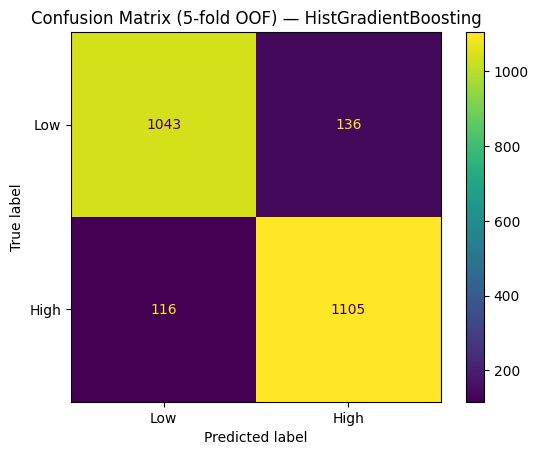

Selected OOF F1: 0.8976
Selected OOF Accuracy: 0.895


In [24]:
# ===================================
# Model Selection (Cross-Validation)
# ===================================


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

def evaluate_model(name, model, X, y):
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    oof_pred = cross_val_predict(pipe, X, y, cv=cv, method="predict")
    f1 = f1_score(y, oof_pred)
    acc = accuracy_score(y, oof_pred)

    print(f"\n{name}\n" + "-" * len(name))
    print(f"F1-score : {f1:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, oof_pred, target_names=["Low", "High"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y, oof_pred))

    return f1, acc, oof_pred

results = {}
for name, model in models.items():
    f1, acc, oof_pred = evaluate_model(name, model, X, y)
    results[name] = {"f1": f1, "acc": acc, "oof_pred": oof_pred}

best_model_name = max(results, key=lambda k: results[k]["f1"])
best_oof_pred = results[best_model_name]["oof_pred"]

print("\nF1 Summary:", {k: round(v["f1"], 4) for k, v in results.items()})
print("Selected model:", best_model_name)

# Confusion matrix plot for the selected model (OOF)
cm = confusion_matrix(y, best_oof_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
plt.figure()
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (5-fold OOF) — {best_model_name}")
plt.show();

print("Selected OOF F1:", round(f1_score(y, best_oof_pred), 4))
print("Selected OOF Accuracy:", round(accuracy_score(y, best_oof_pred), 4))

### Interpretation

- We evaluated multiple model families using **5-fold stratified CV** to ensure reliable generalization estimates.
- The selected model is chosen by **highest F1-score**, balancing precision and recall.
- The OOF confusion matrix provides a realistic view of expected errors on unseen data.

**What Next:** retrain the selected model on the full training dataset and generate `submissions.csv`.

## 10. Train final model and predict test set


We train the selected model on the full training dataset and generate predictions for the test set.
We then export a submission file in the exact required format.

In [25]:
# ======================================
# Train final model and predict test set
# ======================================

best_model = models[best_model_name]

final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X, y)
print("Final model trained on full training data.")

test_pred = final_pipeline.predict(X_test)
pred_labels = pd.Series(test_pred).map({0: "Low", 1: "High"})

print("\nPrediction distribution:")
display(pred_labels.value_counts())

Final model trained on full training data.

Prediction distribution:


Low     313
High    287
Name: count, dtype: int64

### Model Choice Rationale (Why Histogram Gradient Boosting)

Although multiple models performed well, **Histogram Gradient Boosting** was selected because it best matches the structure of this dataset and the business objective.

### Why boosting tends to win on this problem
This dataset contains several characteristics that favor boosted tree models over purely linear approaches:

1. **Nonlinear relationships**
   - Revenue outcomes are rarely linear in raw signals. For example:
     - The jump from 1k → 10k views may matter more than 101k → 110k views (diminishing returns).
     - Ratings effects often saturate (e.g., moving from 8.8 to 9.0 may not change revenue meaningfully).
   - Boosting captures these nonlinear patterns automatically.

2. **Feature interactions**
   - Many predictors interact in real-world content economics:
     - High ratings may translate into High revenue *only when* engagement is also strong.
     - Some genres may perform differently depending on censor rating and country mix.
     - Awards may amplify revenue when combined with strong audience sentiment.
   - Gradient boosting models learn these interactions without manual feature crosses.

3. **Mixed feature types and sparsity**
   - The model input includes:
     - numeric variables (votes, views, ratings, engineered rates)
     - one-hot categories (e.g., censor ratings)
     - multi-hot encoded fields (genres, languages, countries)
   - Boosting models typically handle high-dimensional sparse representations effectively.

4. **Robust generalization**
   - Cross-validation results indicate boosted trees produce the best balance of precision and recall (highest F1-score),
     suggesting better generalization to unseen titles.

### Practical takeaway
We selected Histogram Gradient Boosting because it provides the strongest performance while remaining a reliable choice
for structured/tabular business data where nonlinearities and interactions are expected.

## 11. Create & Validate Submission

In [26]:
# =========================
#  Create submission file
# =========================

submission = pd.DataFrame({
    "title": test_titles,
    "revenue_category": pred_labels
})

# Strict validations
assert submission.shape[0] == test.shape[0], "Row count mismatch with test set."
assert list(submission.columns) == ["title", "revenue_category"], "Submission columns incorrect."
assert submission["revenue_category"].isin(["Low", "High"]).all(), "Invalid label values."

display(submission.head(10))

submission.to_csv("submissions.csv", index=False)
print("✅ submissions.csv created successfully.")

,title,revenue_category
0,Delhi-6,Low
1,Before I Disappear,Low
2,"Good Year, A",High
3,Brüno,High
4,How to Lose a Guy in 10 Days,High
5,Restless,Low
6,Young & Beautiful,Low
7,Iron Man 3,High
8,Invictus,High
9,"SpongeBob SquarePants Movie, The",High


✅ submissions.csv created successfully.


## Final Model & Predictions

The selected model was retrained on the full training dataset and used to
generate predictions for the test set.

A submission file (`submissions.csv`) was produced containing:
- `title`
- `revenue_category` (High / Low)

All submission constraints were validated prior to export.

## Business Impact & Interpretation

The model identifies high-revenue titles by leveraging:
- Viewer engagement intensity and quality
- Content appeal reflected through ratings and awards
- Release timing and lifecycle dynamics

This approach enables Watch-It to prioritize licensing decisions using data-driven
insights, reducing risk and improving expected advertising returns.

## Executive Summary

This notebook delivered an end-to-end, machine learning pipeline to predict movie revenue category for Watch-It licensing.

### Key strengths
- Rigorous integrity checks and EDA focused on business-relevant drivers
- Deterministic cleaning of real-world messy fields (votes, runtime, multi-source ratings)
- Feature engineering aligned to engagement quality and lifecycle timing
- Leakage-safe preprocessing using sklearn pipelines
- Robust model selection using 5-fold stratified cross-validation
- Final predictions exported with strict schema validation

### Business value
The resulting model supports data-driven licensing decisions by prioritizing titles likely to generate **High** advertising revenue, improving expected ROI on content acquisition.